In [1]:
# packages
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import PDESolver_2d, finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# BHmodified 1d
## With no Hotelling constraint
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & - \delta \phi(y) + \delta\eta \log\tilde e \\
&  + \frac{\xi_m}{2} h'h + \frac{d\phi(y)}{dy} \tilde e (\theta + \sigma_y h) + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + (\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h)
\end{aligned}
$$

$$
h^* = - \frac{\frac{d\phi(y)}{dy}\tilde e \sigma_y + (\eta - 1)(\gamma_1 + \gamma_2 y)\tilde e \sigma_y}{\xi_m}
$$
Plug it  back to the HJB:
$$
\begin{aligned}
 0 = \max_{\tilde e} \quad - & \delta\phi(y) + \delta\eta \log\tilde e \\
 & + \frac{d\phi(y)}{dy}\tilde e \theta +  (\eta -1 )(\gamma_1 + \gamma_2 y)\tilde e \theta \\ 
 & + \left[- \frac{1}{2\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}\right] \cdot (\tilde e)^2 |\sigma_y|^2
\end{aligned}
$$

First order condition for $\tilde e ^*$:
$$
  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta\tilde e + \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2
$$

$$
B = \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta
$$

$$
C = \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [2]:
# y grid
δ = 0.01
η = 0.032
ξₘ = 0.004
μ = 1.86/1000
θ = μ
σy = 1.2*θ
num_y = 200
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, num_y)
hy = y_grid[1] - y_grid[0]
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197])

In [18]:
# no constraint ode
def solve_no_constraint(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ, σy, γ1, γ2, γ3, ȳ, ξₘ = args
    hy = y_grid[1] - y_grid[0]
    # initialize the while loop
    episode = 0
    lhs_error = 1
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ϕ =  - δ*η*y_grid**2
    ems = - δ*η/((η-1)*dΛ*θ)
    ems_old = ems
    h_star = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy)
        dϕdyy = derivative_1d(ϕ, 2, hy)

        a = dϕdyy*σy**2 - (dϕdy + (η-1)*dΛ)**2*σy**2/ξₘ 
        b = (dϕdy + (η-1)*dΛ)*θ
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ <0] = 0
        ems_new = (-b - np.sqrt(Δ))/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15    
        ems = ems_new*1 + ems_old*0
        # coefficients
        temp = dϕdy + (η-1)*dΛ
        A = -δ*np.ones(y_grid.shape)
        B = ems*θ
        C = np.zeros(y_grid.shape)
#         C = σy**2*ems**2/2
        D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ - 1/(2*ξₘ)*temp**2*ems**2*σy**2

        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems

In [19]:
γ3 = np.average(γ3_list, weights=[0.5,0.5])
ϕdict = dict()
emsdict = dict()
for ξₘ in [0.002, 1000]:
    args = (δ, η, θ, σy, γ1, γ2, γ3, ȳ, ξₘ)
    ϕdict[ξₘ], emsdict[ξₘ] = solve_no_constraint(y_grid, args)

episode: 1,	 ode error: 0.0016849283859962669,	 ft error: 0.0014465305133519193
episode: 2,	 ode error: 0.0014122613057442244,	 ft error: 0.0012725837524745613
episode: 3,	 ode error: 0.0012123426036814897,	 ft error: 0.001165284558928208
episode: 4,	 ode error: 0.001145712318122692,	 ft error: 0.0011062948973922823
episode: 5,	 ode error: 0.0011175729019886854,	 ft error: 0.0010717485792690303
episode: 6,	 ode error: 0.0010936041919244487,	 ft error: 0.0010377749495251352
episode: 7,	 ode error: 0.011035850963343035,	 ft error: 0.011035855417143602
episode: 8,	 ode error: 0.011002842383317224,	 ft error: 0.011002860008603713
episode: 9,	 ode error: 0.010969932546472416,	 ft error: 0.010969945614936435
episode: 10,	 ode error: 0.010937121131896134,	 ft error: 0.010937138192093748
episode: 11,	 ode error: 0.010904407857175164,	 ft error: 0.01090442490698997
episode: 12,	 ode error: 0.010871792439907327,	 ft error: 0.010871805755945797
episode: 13,	 ode error: 0.010839274537232038,	 ft e

episode: 199,	 ode error: 0.006209250549642011,	 ft error: 0.0062082395776550765
episode: 200,	 ode error: 0.00619068152764262,	 ft error: 0.006189673999797233
episode: 201,	 ode error: 0.0061721680360352724,	 ft error: 0.006171163869115685
episode: 202,	 ode error: 0.006153709908964423,	 ft error: 0.0061527090236163096
episode: 203,	 ode error: 0.006135306981059835,	 ft error: 0.006134309301529436
episode: 204,	 ode error: 0.006116959087435846,	 ft error: 0.006115964541329641
episode: 205,	 ode error: 0.006098666063690602,	 ft error: 0.006097674581747962
episode: 206,	 ode error: 0.0060804277459052414,	 ft error: 0.006079439261787075
episode: 207,	 ode error: 0.006062243970643044,	 ft error: 0.006061258420732204
episode: 208,	 ode error: 0.006044114574948554,	 ft error: 0.006043131898163523
episode: 209,	 ode error: 0.006026039396346656,	 ft error: 0.006025059533965779
episode: 210,	 ode error: 0.006008018272841634,	 ft error: 0.0060070411683406846
episode: 211,	 ode error: 0.00599005

episode: 399,	 ode error: 0.003411182014233365,	 ft error: 0.003410256033923309
episode: 400,	 ode error: 0.0034009818463244185,	 ft error: 0.003400055969648985
episode: 401,	 ode error: 0.0033908121870432776,	 ft error: 0.0033898864270468882
episode: 402,	 ode error: 0.003380672945099236,	 ft error: 0.0033797473146805297
episode: 403,	 ode error: 0.003370564029475072,	 ft error: 0.0033696385413880168
episode: 404,	 ode error: 0.003360485349426249,	 ft error: 0.0033595600162742807
episode: 405,	 ode error: 0.0033504368144801006,	 ft error: 0.0033495116487162564
episode: 406,	 ode error: 0.0033404183344350287,	 ft error: 0.003339493348357333
episode: 407,	 ode error: 0.0033304298193596897,	 ft error: 0.003329505025112904
episode: 408,	 ode error: 0.0033204711795922007,	 ft error: 0.003319546589162966
episode: 409,	 ode error: 0.003310542325739332,	 ft error: 0.0033096179509561896
episode: 410,	 ode error: 0.003300643168675707,	 ft error: 0.00329971902120844
episode: 411,	 ode error: 0.0

episode: 599,	 ode error: 0.0018741688660357664,	 ft error: 0.0018733637777934575
episode: 600,	 ode error: 0.0018685655825856368,	 ft error: 0.0018677611500435751
episode: 601,	 ode error: 0.0018629790567496994,	 ft error: 0.001862175278645554
episode: 602,	 ode error: 0.0018574092384092706,	 ft error: 0.0018566061134761558
episode: 603,	 ode error: 0.0018518560775955782,	 ft error: 0.001851053604564612
episode: 604,	 ode error: 0.0018463195244893173,	 ft error: 0.001845517702086704
episode: 605,	 ode error: 0.001840799529420208,	 ft error: 0.001839998356369943
episode: 606,	 ode error: 0.001835296042866542,	 ft error: 0.0018344955178883904
episode: 607,	 ode error: 0.0018298090154547416,	 ft error: 0.0018290091372667276
episode: 608,	 ode error: 0.001824338397958914,	 ft error: 0.0018235391652761854
episode: 609,	 ode error: 0.0018188841413004121,	 ft error: 0.0018180855528338036
episode: 610,	 ode error: 0.0018134461965473893,	 ft error: 0.001812648251007613
episode: 611,	 ode error

episode: 804,	 ode error: 0.0011043645356668432,	 ft error: 0.0010138292212532227
episode: 805,	 ode error: 0.0011048559201509455,	 ft error: 0.0010107972489629506
episode: 806,	 ode error: 0.0011053461082562723,	 ft error: 0.0010077743444902865
episode: 807,	 ode error: 0.0011058351025164692,	 ft error: 0.0010047604807161825
episode: 808,	 ode error: 0.0011063229054620856,	 ft error: 0.0010017556306015272
episode: 809,	 ode error: 0.0011068095196205643,	 ft error: 0.0009987597671893649
episode: 810,	 ode error: 0.0011072949475162252,	 ft error: 0.0009957728636011964
episode: 811,	 ode error: 0.0011077791916702532,	 ft error: 0.0009927948930406791
episode: 812,	 ode error: 0.0011082622546006874,	 ft error: 0.0009898258287914057
episode: 813,	 ode error: 0.0011087441388224044,	 ft error: 0.0009868656442169055
episode: 814,	 ode error: 0.0011092248468471083,	 ft error: 0.000983914312760644
episode: 815,	 ode error: 0.0011097043811833169,	 ft error: 0.0009809718079430616
episode: 816,	 od

episode: 1010,	 ode error: 0.0011837149560554614,	 ft error: 0.00054703262211205
episode: 1011,	 ode error: 0.0011840083642935882,	 ft error: 0.0005453967040843407
episode: 1012,	 ode error: 0.0011843010229305295,	 ft error: 0.0005437656785526694
episode: 1013,	 ode error: 0.0011845929337522482,	 ft error: 0.0005421395308857768
episode: 1014,	 ode error: 0.0011848840985410967,	 ft error: 0.0005405182464931121
episode: 1015,	 ode error: 0.0011851745190758212,	 ft error: 0.0005389018108307535
episode: 1016,	 ode error: 0.0011854641971315648,	 ft error: 0.000537290209397708
episode: 1017,	 ode error: 0.0011857531344798707,	 ft error: 0.0005356834277336908
episode: 1018,	 ode error: 0.001186041332888688,	 ft error: 0.0005340814514250466
episode: 1019,	 ode error: 0.0011863287941223705,	 ft error: 0.0005324842661003082
episode: 1020,	 ode error: 0.0011866155199416867,	 ft error: 0.0005308918574287169
episode: 1021,	 ode error: 0.0011869015121038172,	 ft error: 0.0005293042111246631
episode:

episode: 1209,	 ode error: 0.0012294270836908719,	 ft error: 0.000301421409704498
episode: 1210,	 ode error: 0.0012296021015663287,	 ft error: 0.00030052002386519544
episode: 1211,	 ode error: 0.0012297766596931054,	 ft error: 0.00029962133368958516
episode: 1212,	 ode error: 0.0012299507592267625,	 ft error: 0.0002987253311100465
episode: 1213,	 ode error: 0.0012301244013201856,	 ft error: 0.0002978320080922655
episode: 1214,	 ode error: 0.0012302975871235904,	 ft error: 0.0002969413566204319
episode: 1215,	 ode error: 0.0012304703177845296,	 ft error: 0.0002960533687053809
episode: 1216,	 ode error: 0.001230642594447897,	 ft error: 0.00029516803638163225
episode: 1217,	 ode error: 0.0012308144182559325,	 ft error: 0.00029428535170517023
episode: 1218,	 ode error: 0.0012309857903482265,	 ft error: 0.0002934053067608448
episode: 1219,	 ode error: 0.0012311567118617247,	 ft error: 0.00029252789365200965
episode: 1220,	 ode error: 0.0012313271839307339,	 ft error: 0.00029165310450496307


episode: 1412,	 ode error: 0.001256946622177095,	 ft error: 0.0001641113751256936
episode: 1413,	 ode error: 0.0012570486649396652,	 ft error: 0.00016362061899144464
episode: 1414,	 ode error: 0.0012571504343325936,	 ft error: 0.00016313133045287032
episode: 1415,	 ode error: 0.0012572519310656842,	 ft error: 0.00016264350512162906
episode: 1416,	 ode error: 0.0012573531558469865,	 ft error: 0.00016215713862196188
episode: 1417,	 ode error: 0.0012574541093828052,	 ft error: 0.00016167222659069225
episode: 1418,	 ode error: 0.0012575547923776996,	 ft error: 0.00016118876467722626
episode: 1419,	 ode error: 0.0012576552055344878,	 ft error: 0.00016070674854577288
episode: 1420,	 ode error: 0.0012577553495542538,	 ft error: 0.00016022617387238353
episode: 1421,	 ode error: 0.0012578552251363484,	 ft error: 0.0001597470363471724
episode: 1422,	 ode error: 0.0012579548329783937,	 ft error: 0.00015926933166987567
episode: 1423,	 ode error: 0.0012580541737762885,	 ft error: 0.0001587930555579

episode: 1615,	 ode error: 0.0012729212484083108,	 ft error: 8.93528524007851e-05
episode: 1616,	 ode error: 0.0012729801946790233,	 ft error: 8.908565759302434e-05
episode: 1617,	 ode error: 0.0012730389806792494,	 ft error: 8.881926180685322e-05
episode: 1618,	 ode error: 0.0012730976068344468,	 ft error: 8.855366265381193e-05
episode: 1619,	 ode error: 0.00127315607356898,	 ft error: 8.828885774988157e-05
episode: 1620,	 ode error: 0.0012732143813061296,	 ft error: 8.80248447214053e-05
episode: 1621,	 ode error: 0.0012732725304680863,	 ft error: 8.776162119990735e-05
episode: 1622,	 ode error: 0.0012733305214759627,	 ft error: 8.749918482283311e-05
episode: 1623,	 ode error: 0.00127338835474979,	 ft error: 8.723753323799008e-05
episode: 1624,	 ode error: 0.0012734460307085235,	 ft error: 8.697666409762661e-05
episode: 1625,	 ode error: 0.0012735035497700433,	 ft error: 8.671657506287289e-05
episode: 1626,	 ode error: 0.0012735609123511577,	 ft error: 8.645726379929997e-05
episode: 1

episode: 1816,	 ode error: 0.001282049715538549,	 ft error: 4.8942201663996584e-05
episode: 1817,	 ode error: 0.0012820837055106862,	 ft error: 4.879585023894369e-05
episode: 1818,	 ode error: 0.0012821176019785826,	 ft error: 4.864993645714577e-05
episode: 1819,	 ode error: 0.0012821514051945542,	 ft error: 4.85044590092798e-05
episode: 1820,	 ode error: 0.0012821851154102525,	 ft error: 4.835941659046365e-05
episode: 1821,	 ode error: 0.001282218732876669,	 ft error: 4.821480790025608e-05
episode: 1822,	 ode error: 0.0012822522578441352,	 ft error: 4.807063164117646e-05
episode: 1823,	 ode error: 0.001282285690562325,	 ft error: 4.792688652018503e-05
episode: 1824,	 ode error: 0.0012823190312802567,	 ft error: 4.778357124942308e-05
episode: 1825,	 ode error: 0.001282352280246291,	 ft error: 4.764068454177206e-05
episode: 1826,	 ode error: 0.0012823854377081406,	 ft error: 4.74982251145543e-05
episode: 1827,	 ode error: 0.001282418503912864,	 ft error: 4.735619169323376e-05
episode: 1

episode: 2018,	 ode error: 0.0012873184486708127,	 ft error: 2.67276925525195e-05
episode: 2019,	 ode error: 0.0012873378787598253,	 ft error: 2.6647769985436536e-05
episode: 2020,	 ode error: 0.0012873572548750124,	 ft error: 2.656808641088304e-05
episode: 2021,	 ode error: 0.0012873765771639306,	 ft error: 2.6488641115355687e-05
episode: 2022,	 ode error: 0.0012873958457737407,	 ft error: 2.6409433385351143e-05
episode: 2023,	 ode error: 0.0012874150608512104,	 ft error: 2.6330462512547115e-05
episode: 2024,	 ode error: 0.0012874342225427141,	 ft error: 2.625172778714102e-05
episode: 2025,	 ode error: 0.0012874533309942368,	 ft error: 2.617322850303102e-05
episode: 2026,	 ode error: 0.0012874723863513667,	 ft error: 2.609496395485541e-05
episode: 2027,	 ode error: 0.00128749138875931,	 ft error: 2.6016933442433537e-05
episode: 2028,	 ode error: 0.0012875103383628785,	 ft error: 2.5939136267805196e-05
episode: 2029,	 ode error: 0.0012875292353064993,	 ft error: 2.586157172782914e-05
e

episode: 2216,	 ode error: 0.0012902787289149446,	 ft error: 1.477219215099505e-05
episode: 2217,	 ode error: 0.0012902899048396017,	 ft error: 1.4728020062045507e-05
episode: 2218,	 ode error: 0.001290301049467319,	 ft error: 1.4683980060029949e-05
episode: 2219,	 ode error: 0.001290312162884561,	 ft error: 1.4640071749708976e-05
episode: 2220,	 ode error: 0.00129032324517756,	 ft error: 1.459629473732349e-05
episode: 2221,	 ode error: 0.0012903342964323125,	 ft error: 1.4552648629854541e-05
episode: 2222,	 ode error: 0.0012903453167345833,	 ft error: 1.4509133035763474e-05
episode: 2223,	 ode error: 0.001290356306169901,	 ft error: 1.4465747564991934e-05
episode: 2224,	 ode error: 0.0012903672648235652,	 ft error: 1.442249183044216e-05
episode: 2225,	 ode error: 0.001290378192780643,	 ft error: 1.4379365441315647e-05
episode: 2226,	 ode error: 0.0012903890901259701,	 ft error: 1.4336368012735079e-05
episode: 2227,	 ode error: 0.0012903999569441509,	 ft error: 1.4293499156862548e-05
e

episode: 2419,	 ode error: 0.0012920099842115649,	 ft error: 8.043192289974854e-06
episode: 2420,	 ode error: 0.001292016295954187,	 ft error: 8.019141648496486e-06
episode: 2421,	 ode error: 0.0012920225898952428,	 ft error: 7.99516292356491e-06
episode: 2422,	 ode error: 0.0012920288660843628,	 ft error: 7.971255900537008e-06
episode: 2423,	 ode error: 0.0012920351245710414,	 ft error: 7.94742036550981e-06
episode: 2424,	 ode error: 0.001292041365404636,	 ft error: 7.923656104580346e-06
episode: 2425,	 ode error: 0.001292047588634368,	 ft error: 7.899962903845648e-06
episode: 2426,	 ode error: 0.0012920537943093245,	 ft error: 7.876340552363342e-06
episode: 2427,	 ode error: 0.0012920599824784566,	 ft error: 7.852788837710753e-06
episode: 2428,	 ode error: 0.0012920661531905836,	 ft error: 7.829307546725062e-06
episode: 2429,	 ode error: 0.0012920723064943874,	 ft error: 7.805896470684342e-06
episode: 2430,	 ode error: 0.0012920784424384165,	 ft error: 7.782555400126512e-06
episode: 

episode: 2621,	 ode error: 0.0012929824569444586,	 ft error: 4.392535889093571e-06
episode: 2622,	 ode error: 0.001292986018157131,	 ft error: 4.3794015236464645e-06
episode: 2623,	 ode error: 0.0012929895692640257,	 ft error: 4.3663064319687805e-06
episode: 2624,	 ode error: 0.001292993110293537,	 ft error: 4.353250499337473e-06
episode: 2625,	 ode error: 0.0012929966412739775,	 ft error: 4.340233604368157e-06
episode: 2626,	 ode error: 0.0012930001622335823,	 ft error: 4.327255633077935e-06
episode: 2627,	 ode error: 0.0012930036732005095,	 ft error: 4.314316470003614e-06
episode: 2628,	 ode error: 0.0012930071742028367,	 ft error: 4.301415995981254e-06
episode: 2629,	 ode error: 0.001293010665268564,	 ft error: 4.28855409702796e-06
episode: 2630,	 ode error: 0.0012930141464256159,	 ft error: 4.275730659160834e-06
episode: 2631,	 ode error: 0.0012930176177018363,	 ft error: 4.262945565436382e-06
episode: 2632,	 ode error: 0.001293021079124994,	 ft error: 4.250198701131562e-06
episode

episode: 2824,	 ode error: 0.0012935323163137749,	 ft error: 2.3916864725729665e-06
episode: 2825,	 ode error: 0.0012935343133013031,	 ft error: 2.384535028691441e-06
episode: 2826,	 ode error: 0.0012935363045913704,	 ft error: 2.377404966225072e-06
episode: 2827,	 ode error: 0.001293538290200093,	 ft error: 2.370296224481668e-06
episode: 2828,	 ode error: 0.00129354027014354,	 ft error: 2.363208739068294e-06
episode: 2829,	 ode error: 0.0012935422444377356,	 ft error: 2.356142446332162e-06
episode: 2830,	 ode error: 0.0012935442130986591,	 ft error: 2.349097283360635e-06
episode: 2831,	 ode error: 0.0012935461761422462,	 ft error: 2.342073186500926e-06
episode: 2832,	 ode error: 0.0012935481335843858,	 ft error: 2.3350700928403967e-06
episode: 2833,	 ode error: 0.0012935500854409248,	 ft error: 2.328087940206558e-06
episode: 2834,	 ode error: 0.0012935520317276642,	 ft error: 2.321126664946623e-06
episode: 2835,	 ode error: 0.0012935539724603612,	 ft error: 2.314186203407805e-06
episo

episode: 3028,	 ode error: 0.0012938413578342078,	 ft error: 1.2983599151361602e-06
episode: 3029,	 ode error: 0.0012938424711951976,	 ft error: 1.294477689484097e-06
episode: 3030,	 ode error: 0.0012938435813646626,	 ft error: 1.2906070723239793e-06
episode: 3031,	 ode error: 0.0012938446883516825,	 ft error: 1.2867480281286703e-06
episode: 3032,	 ode error: 0.0012938457921653108,	 ft error: 1.2829005235914792e-06
episode: 3033,	 ode error: 0.0012938468928145761,	 ft error: 1.2790645231852693e-06
episode: 3034,	 ode error: 0.001293847990308483,	 ft error: 1.2752399928632012e-06
episode: 3035,	 ode error: 0.0012938490846560059,	 ft error: 1.271426899318584e-06
episode: 3036,	 ode error: 0.0012938501758660986,	 ft error: 1.2676252077644299e-06
episode: 3037,	 ode error: 0.0012938512639476896,	 ft error: 1.2638348826736017e-06
episode: 3038,	 ode error: 0.001293852348909679,	 ft error: 1.2600558914795576e-06
episode: 3039,	 ode error: 0.0012938534307609445,	 ft error: 1.256288200135458e-

episode: 3229,	 ode error: 0.001294011580543224,	 ft error: 7.111968273558016e-07
episode: 3230,	 ode error: 0.0012940122050255011,	 ft error: 7.090702958123529e-07
episode: 3231,	 ode error: 0.0012940128277102812,	 ft error: 7.069501221460921e-07
episode: 3232,	 ode error: 0.0012940134486027041,	 ft error: 7.048362878533018e-07
episode: 3233,	 ode error: 0.0012940140677078942,	 ft error: 7.02728774430265e-07
episode: 3234,	 ode error: 0.0012940146850309625,	 ft error: 7.006275618929674e-07
episode: 3235,	 ode error: 0.0012940153005770037,	 ft error: 6.985326339581377e-07
episode: 3236,	 ode error: 0.0012940159143511008,	 ft error: 6.964439691614643e-07
episode: 3237,	 ode error: 0.001294016526358319,	 ft error: 6.943615497393789e-07
episode: 3238,	 ode error: 0.001294017136603712,	 ft error: 6.922853571881642e-07
episode: 3239,	 ode error: 0.0012940177450923174,	 ft error: 6.902153730041032e-07
episode: 3240,	 ode error: 0.0012940183518291599,	 ft error: 6.881515772031814e-07
episode:

episode: 3434,	 ode error: 0.0012941083516082176,	 ft error: 3.8493249032711674e-07
episode: 3435,	 ode error: 0.0012941086970720819,	 ft error: 3.8378152211748784e-07
episode: 3436,	 ode error: 0.0012941090415378737,	 ft error: 3.826339948590866e-07
episode: 3437,	 ode error: 0.0012941093850084586,	 ft error: 3.814898996701288e-07
episode: 3438,	 ode error: 0.0012941097274866966,	 ft error: 3.8034922544838423e-07
episode: 3439,	 ode error: 0.0012941100689754358,	 ft error: 3.792119618317713e-07
episode: 3440,	 ode error: 0.00129411040947752,	 ft error: 3.780780984582085e-07
episode: 3441,	 ode error: 0.0012941107489957823,	 ft error: 3.7694762570576284e-07
episode: 3442,	 ode error: 0.0012941110875330487,	 ft error: 3.7582053321235287e-07
episode: 3443,	 ode error: 0.0012941114250921378,	 ft error: 3.7469681061589693e-07
episode: 3444,	 ode error: 0.0012941117616758588,	 ft error: 3.7357644681416485e-07
episode: 3445,	 ode error: 0.0012941120972870131,	 ft error: 3.7245943440566975e-0

episode: 3638,	 ode error: 0.0012941616432254317,	 ft error: 2.089689858190506e-07
episode: 3639,	 ode error: 0.001294161834494059,	 ft error: 2.0834416266287312e-07
episode: 3640,	 ode error: 0.0012941620252082816,	 ft error: 2.0772120690182305e-07
episode: 3641,	 ode error: 0.0012941622153696986,	 ft error: 2.07100114835157e-07
episode: 3642,	 ode error: 0.001294162404979904,	 ft error: 2.0648087906138812e-07
episode: 3643,	 ode error: 0.0012941625940404878,	 ft error: 2.0586349513962432e-07
episode: 3644,	 ode error: 0.0012941627825530343,	 ft error: 2.0524795640852744e-07
episode: 3645,	 ode error: 0.0012941629705191234,	 ft error: 2.0463425990750278e-07
episode: 3646,	 ode error: 0.001294163157940331,	 ft error: 2.0402239675476608e-07
episode: 3647,	 ode error: 0.00129416334481823,	 ft error: 2.0341236398972268e-07
episode: 3648,	 ode error: 0.0012941635311543855,	 ft error: 2.0280415495103438e-07
episode: 3649,	 ode error: 0.0012941637169503605,	 ft error: 2.021977644576604e-07
e

episode: 3842,	 ode error: 0.0012941911237488372,	 ft error: 1.1344384764910842e-07
episode: 3843,	 ode error: 0.001294191229452005,	 ft error: 1.1310464935003021e-07
episode: 3844,	 ode error: 0.0012941913348478895,	 ft error: 1.1276646505464782e-07
episode: 3845,	 ode error: 0.0012941914399373805,	 ft error: 1.1242929254251521e-07
episode: 3846,	 ode error: 0.001294191544721365,	 ft error: 1.1209312737274028e-07
episode: 3847,	 ode error: 0.0012941916492007254,	 ft error: 1.1175796806502566e-07
episode: 3848,	 ode error: 0.001294191753376345,	 ft error: 1.1142381091862794e-07
episode: 3849,	 ode error: 0.0012941918572491008,	 ft error: 1.1109065297295237e-07
episode: 3850,	 ode error: 0.0012941919608198717,	 ft error: 1.1075849126740422e-07
episode: 3851,	 ode error: 0.0012941920640895293,	 ft error: 1.1042732210124011e-07
episode: 3852,	 ode error: 0.0012941921670589463,	 ft error: 1.1009714251386526e-07
episode: 3853,	 ode error: 0.0012941922697289924,	 ft error: 1.0976795102498235

episode: 4044,	 ode error: 0.0012942072865562305,	 ft error: 6.195590929181094e-08
episode: 4045,	 ode error: 0.001294207345217927,	 ft error: 6.177066191881408e-08
episode: 4046,	 ode error: 0.001294207403708651,	 ft error: 6.158596817703218e-08
episode: 4047,	 ode error: 0.001294207462028899,	 ft error: 6.140182658616786e-08
episode: 4048,	 ode error: 0.0012942075201791657,	 ft error: 6.121823566592374e-08
episode: 4049,	 ode error: 0.001294207578159944,	 ft error: 6.103519393600247e-08
episode: 4050,	 ode error: 0.0012942076359717253,	 ft error: 6.085269917595801e-08
episode: 4051,	 ode error: 0.001294207693615001,	 ft error: 6.067074990549297e-08
episode: 4052,	 ode error: 0.00129420775109026,	 ft error: 6.048934464431e-08
episode: 4053,	 ode error: 0.0012942078083979904,	 ft error: 6.030848265226041e-08
episode: 4054,	 ode error: 0.001294207865538677,	 ft error: 6.012816022860079e-08
episode: 4055,	 ode error: 0.001294207922512807,	 ft error: 5.994837811347983e-08
episode: 4056,	 

episode: 4249,	 ode error: 0.0012942163476812227,	 ft error: 3.353394599040864e-08
episode: 4250,	 ode error: 0.0012942163799054,	 ft error: 3.3433681008906056e-08
episode: 4251,	 ode error: 0.0012942164120354374,	 ft error: 3.333371504747144e-08
episode: 4252,	 ode error: 0.0012942164440716084,	 ft error: 3.323404736595611e-08
episode: 4253,	 ode error: 0.0012942164760141868,	 ft error: 3.3134678704508744e-08
episode: 4254,	 ode error: 0.001294216507863444,	 ft error: 3.303560758283197e-08
episode: 4255,	 ode error: 0.0012942165396196536,	 ft error: 3.293683104033107e-08
episode: 4256,	 ode error: 0.0012942165712830846,	 ft error: 3.283835203760077e-08
episode: 4257,	 ode error: 0.0012942166028540075,	 ft error: 3.274016539360029e-08
episode: 4258,	 ode error: 0.001294216634332692,	 ft error: 3.2642272588626994e-08
episode: 4259,	 ode error: 0.0012942166657194062,	 ft error: 3.2544672882532197e-08
episode: 4260,	 ode error: 0.0012942166970144183,	 ft error: 3.2447365535167215e-08
epis

episode: 4454,	 ode error: 0.0012942213221193487,	 ft error: 1.815047815748964e-08
episode: 4455,	 ode error: 0.0012942213397971417,	 ft error: 1.8096208975748596e-08
episode: 4456,	 ode error: 0.0012942213574231817,	 ft error: 1.804210262671783e-08
episode: 4457,	 ode error: 0.00129422137499762,	 ft error: 1.7988156889951295e-08
episode: 4458,	 ode error: 0.0012942213925206062,	 ft error: 1.7934373245746354e-08
episode: 4459,	 ode error: 0.0012942214099922907,	 ft error: 1.788075021380564e-08
episode: 4460,	 ode error: 0.0012942214274128236,	 ft error: 1.782728779412916e-08
episode: 4461,	 ode error: 0.001294221444782354,	 ft error: 1.7773984506419538e-08
episode: 4462,	 ode error: 0.0012942214621010307,	 ft error: 1.7720841830974148e-08
episode: 4463,	 ode error: 0.0012942214793690025,	 ft error: 1.7667856807198255e-08
episode: 4464,	 ode error: 0.0012942214965864169,	 ft error: 1.761503017524054e-08
episode: 4465,	 ode error: 0.0012942215137534217,	 ft error: 1.7562362675249688e-08


episode: 4654,	 ode error: 0.001294224000675726,	 ft error: 9.972297062195897e-09
episode: 1,	 ode error: 0.001690483772540639,	 ft error: 0.0014591622630292513
episode: 2,	 ode error: 0.0014326885606511781,	 ft error: 0.0013232688808458638
episode: 3,	 ode error: 0.0012488500231809354,	 ft error: 0.0012380988547502933
episode: 4,	 ode error: 0.0012846359748356878,	 ft error: 0.0012133419598130547
episode: 5,	 ode error: 0.001231403443847833,	 ft error: 0.0011767519286981188
episode: 6,	 ode error: 0.001181789930546393,	 ft error: 0.001139596342966226
episode: 7,	 ode error: 0.0011446552443449005,	 ft error: 0.0011088189396956075
episode: 8,	 ode error: 0.0011132317936156794,	 ft error: 0.0010853631409436966
episode: 9,	 ode error: 0.0010842162271546337,	 ft error: 0.0010607222497895172
episode: 10,	 ode error: 0.0010614553444462126,	 ft error: 0.001039148925134919
episode: 11,	 ode error: 0.001041102089110286,	 ft error: 0.0010223920630770334
episode: 12,	 ode error: 0.001020996812798

episode: 178,	 ode error: 0.0003679059592230842,	 ft error: 0.00035170351278653034
episode: 179,	 ode error: 0.00036617436360001396,	 ft error: 0.0003499046026469536
episode: 180,	 ode error: 0.00036445047122708914,	 ft error: 0.000348113349050716
episode: 181,	 ode error: 0.00036273427912144457,	 ft error: 0.0003463297402729604
episode: 182,	 ode error: 0.0003610257847449633,	 ft error: 0.00034455376587173847
episode: 183,	 ode error: 0.00035932498591813625,	 ft error: 0.00034278541657536965
episode: 184,	 ode error: 0.0003576318807386133,	 ft error: 0.00034102468417343085
episode: 185,	 ode error: 0.0003559464675042314,	 ft error: 0.00033927156141278875
episode: 186,	 ode error: 0.0003542687446404072,	 ft error: 0.0003375260418965002
episode: 187,	 ode error: 0.0003525987106320083,	 ft error: 0.0003357881199882867
episode: 188,	 ode error: 0.0003509363639592292,	 ft error: 0.0003340577907199235
episode: 189,	 ode error: 0.0003492817030377066,	 ft error: 0.00033233504970362393
episode

episode: 381,	 ode error: 0.00012352779063984506,	 ft error: 0.00012344519443760935
episode: 382,	 ode error: 0.00012290971903852776,	 ft error: 0.00012282793729052427
episode: 383,	 ode error: 0.0001222949831450222,	 ft error: 0.00012221400276436756
episode: 384,	 ode error: 0.00012168356297051367,	 ft error: 0.0001216033707052607
episode: 385,	 ode error: 0.00012107543864863966,	 ft error: 0.00012099602107414065
episode: 386,	 ode error: 0.00012047059043505514,	 ft error: 0.00012039193394303613
episode: 387,	 ode error: 0.00011986899870695619,	 ft error: 0.00011979108950387989
episode: 388,	 ode error: 0.00011927064396268319,	 ft error: 0.00011919346805428407
episode: 389,	 ode error: 0.0001186755068212609,	 ft error: 0.00011859905000815667
episode: 390,	 ode error: 0.0001180835680220008,	 ft error: 0.00011800781588922524
episode: 391,	 ode error: 0.00011749480842399701,	 ft error: 0.00011741974633048177
episode: 392,	 ode error: 0.000116909209005687,	 ft error: 0.0001168348220745990

episode: 588,	 ode error: 4.510973501794255e-05,	 ft error: 4.5241680900383795e-05
episode: 589,	 ode error: 4.489586368310841e-05,	 ft error: 4.502774745768675e-05
episode: 590,	 ode error: 4.4683046400666626e-05,	 ft error: 4.481487390466573e-05
episode: 591,	 ode error: 4.4471277579637364e-05,	 ft error: 4.460305444084489e-05
episode: 592,	 ode error: 4.4260551660194156e-05,	 ft error: 4.4392283301529965e-05
episode: 593,	 ode error: 4.405086311357596e-05,	 ft error: 4.4182554764053236e-05
episode: 594,	 ode error: 4.3842206441901434e-05,	 ft error: 4.397386314330953e-05
episode: 595,	 ode error: 4.363457617807126e-05,	 ft error: 4.3766202792149454e-05
episode: 596,	 ode error: 4.342796688567945e-05,	 ft error: 4.355956810207322e-05
episode: 597,	 ode error: 4.322237315882067e-05,	 ft error: 4.335395350110276e-05
episode: 598,	 ode error: 4.301778962203216e-05,	 ft error: 4.314935345625659e-05
episode: 599,	 ode error: 4.281421093010917e-05,	 ft error: 4.294576246707353e-05
episode:

episode: 795,	 ode error: 1.7072058067783467e-05,	 ft error: 1.721915724434605e-05
episode: 796,	 ode error: 1.6992384772191718e-05,	 ft error: 1.713955603147947e-05
episode: 797,	 ode error: 1.691307647184797e-05,	 ft error: 1.706031958437678e-05
episode: 798,	 ode error: 1.6834131451578757e-05,	 ft error: 1.69814461915598e-05
episode: 799,	 ode error: 1.6755548009764437e-05,	 ft error: 1.6902934154734244e-05
episode: 800,	 ode error: 1.6677324458223624e-05,	 ft error: 1.6824781789576138e-05
episode: 801,	 ode error: 1.659945912207061e-05,	 ft error: 1.6746987424043347e-05
episode: 802,	 ode error: 1.6521950339545258e-05,	 ft error: 1.666954940052664e-05
episode: 803,	 ode error: 1.644479646184787e-05,	 ft error: 1.659246607268091e-05
episode: 804,	 ode error: 1.6367995852962255e-05,	 ft error: 1.6515735809149078e-05
episode: 805,	 ode error: 1.62915468894919e-05,	 ft error: 1.6439356989074914e-05
episode: 806,	 ode error: 1.6215447960468503e-05,	 ft error: 1.6363328004531663e-05
epis

episode: 1001,	 ode error: 6.463858593161367e-06,	 ft error: 6.621940558509029e-06
episode: 1002,	 ode error: 6.43312873926515e-06,	 ft error: 6.591244620356615e-06
episode: 1003,	 ode error: 6.406616216213831e-06,	 ft error: 6.560688970540704e-06
episode: 1004,	 ode error: 6.389418885475767e-06,	 ft error: 6.530272952248728e-06
episode: 1005,	 ode error: 6.372301391836441e-06,	 ft error: 6.499995912646421e-06
episode: 1006,	 ode error: 6.355263373639889e-06,	 ft error: 6.469857201906367e-06
episode: 1007,	 ode error: 6.338304470869787e-06,	 ft error: 6.439856174225711e-06
episode: 1008,	 ode error: 6.321424325143811e-06,	 ft error: 6.409992186368989e-06
episode: 1009,	 ode error: 6.304622579711471e-06,	 ft error: 6.380264599171552e-06
episode: 1010,	 ode error: 6.287898879436165e-06,	 ft error: 6.350672776267441e-06
episode: 1011,	 ode error: 6.2712528708043416e-06,	 ft error: 6.3212160848757915e-06
episode: 1012,	 ode error: 6.254684201898884e-06,	 ft error: 6.291893895615797e-06
epi

episode: 1207,	 ode error: 4.1439088249766104e-06,	 ft error: 2.5152527393749553e-06
episode: 1208,	 ode error: 4.137353012247016e-06,	 ft error: 2.503274718924457e-06
episode: 1209,	 ode error: 4.130828760826434e-06,	 ft error: 2.4913513995324563e-06
episode: 1210,	 ode error: 4.124335926703653e-06,	 ft error: 2.479482534798831e-06
episode: 1211,	 ode error: 4.117874366498897e-06,	 ft error: 2.46766787816155e-06
episode: 1212,	 ode error: 4.111443937484865e-06,	 ft error: 2.4559071855797163e-06
episode: 1213,	 ode error: 4.1050444975591904e-06,	 ft error: 2.444200212758004e-06
episode: 1214,	 ode error: 4.0986759052725205e-06,	 ft error: 2.432546717089553e-06
episode: 1215,	 ode error: 4.092338019806726e-06,	 ft error: 2.4209464575403183e-06
episode: 1216,	 ode error: 4.086030700962647e-06,	 ft error: 2.409399193677627e-06
episode: 1217,	 ode error: 4.079753809173542e-06,	 ft error: 2.397904685878342e-06
episode: 1218,	 ode error: 4.0735072055058394e-06,	 ft error: 2.3864626962309217e

episode: 1413,	 ode error: 3.292660635132328e-06,	 ft error: 1.147512363360026e-06
episode: 1414,	 ode error: 3.290314022622227e-06,	 ft error: 1.1440806337720266e-06
episode: 1415,	 ode error: 3.2879795697511984e-06,	 ft error: 1.1406590830094025e-06
episode: 1416,	 ode error: 3.2856572194278665e-06,	 ft error: 1.1372476813621228e-06
episode: 1417,	 ode error: 3.283346914821064e-06,	 ft error: 1.1338463989351197e-06
episode: 1418,	 ode error: 3.28104859935376e-06,	 ft error: 1.1304552061571402e-06
episode: 1419,	 ode error: 3.278762216710001e-06,	 ft error: 1.1270740732834592e-06
episode: 1420,	 ode error: 3.2764877108213547e-06,	 ft error: 1.1237029705346568e-06
episode: 1421,	 ode error: 3.274225025866372e-06,	 ft error: 1.1203418689871107e-06
episode: 1422,	 ode error: 3.2719741062919427e-06,	 ft error: 1.1169907386301046e-06
episode: 1423,	 ode error: 3.2697348967741574e-06,	 ft error: 1.1136495505978394e-06
episode: 1424,	 ode error: 3.2675073422520256e-06,	 ft error: 1.110318275

episode: 1621,	 ode error: 2.9983490317048384e-06,	 ft error: 6.152125014864211e-07
episode: 1622,	 ode error: 2.9976095010378822e-06,	 ft error: 6.133722498316563e-07
episode: 1623,	 ode error: 2.996874423238146e-06,	 ft error: 6.11537458299986e-07
episode: 1624,	 ode error: 2.9961437761557045e-06,	 ft error: 6.097081107931761e-07
episode: 1625,	 ode error: 2.9954175377407046e-06,	 ft error: 6.078841913286411e-07
episode: 1626,	 ode error: 2.9946956860437985e-06,	 ft error: 6.060656838312769e-07
episode: 1627,	 ode error: 2.9939781992147346e-06,	 ft error: 6.042525725382294e-07
episode: 1628,	 ode error: 2.993265055505935e-06,	 ft error: 6.024448413859592e-07
episode: 1629,	 ode error: 2.9925562332658827e-06,	 ft error: 6.006424748197792e-07
episode: 1630,	 ode error: 2.991851710951697e-06,	 ft error: 5.988454570190113e-07
episode: 1631,	 ode error: 2.9911514671140645e-06,	 ft error: 5.970537722092366e-07
episode: 1632,	 ode error: 2.9904554804059116e-06,	 ft error: 5.952674045466474e

episode: 1828,	 ode error: 2.9143149824595142e-06,	 ft error: 3.3080486248430557e-07
episode: 1829,	 ode error: 2.914144901508672e-06,	 ft error: 3.298150486284272e-07
episode: 1830,	 ode error: 2.9139763255430938e-06,	 ft error: 3.288281727233574e-07
episode: 1831,	 ode error: 2.913809246198702e-06,	 ft error: 3.2784422588731193e-07
episode: 1832,	 ode error: 2.913643655148173e-06,	 ft error: 3.268631997242292e-07
episode: 1833,	 ode error: 2.913479544110263e-06,	 ft error: 3.2588508561831597e-07
episode: 1834,	 ode error: 2.913316904840156e-06,	 ft error: 3.2490987498847346e-07
episode: 1835,	 ode error: 2.913155729137055e-06,	 ft error: 3.239375592189083e-07
episode: 1836,	 ode error: 2.912996008830847e-06,	 ft error: 3.2296812985573486e-07
episode: 1837,	 ode error: 2.9128377357977124e-06,	 ft error: 3.220015784335025e-07
episode: 1838,	 ode error: 2.9126809019530816e-06,	 ft error: 3.210378964289366e-07
episode: 1839,	 ode error: 2.9125254992480544e-06,	 ft error: 3.20077075376586

episode: 2034,	 ode error: 2.9015144253601976e-06,	 ft error: 1.7840229703247612e-07
episode: 2035,	 ode error: 2.901524355854992e-06,	 ft error: 1.778682869278218e-07
episode: 2036,	 ode error: 2.9015347064812727e-06,	 ft error: 1.7733586259172096e-07
episode: 2037,	 ode error: 2.9015454742619285e-06,	 ft error: 1.7680501930572579e-07
episode: 2038,	 ode error: 2.901556656232751e-06,	 ft error: 1.7627575224730502e-07
episode: 2039,	 ode error: 2.9015682494423246e-06,	 ft error: 1.7574805713747404e-07
episode: 2040,	 ode error: 2.901580250962545e-06,	 ft error: 1.7522192906118303e-07
episode: 2041,	 ode error: 2.9015926578752817e-06,	 ft error: 1.7469736350815096e-07
episode: 2042,	 ode error: 2.901605467276608e-06,	 ft error: 1.741743559334023e-07
episode: 2043,	 ode error: 2.9016186762833044e-06,	 ft error: 1.7365290168787814e-07
episode: 2044,	 ode error: 2.901632282021477e-06,	 ft error: 1.7313299605313065e-07
episode: 2045,	 ode error: 2.901646281631867e-06,	 ft error: 1.726146346

episode: 2241,	 ode error: 2.9091548870417185e-06,	 ft error: 9.591893066855188e-08
episode: 2242,	 ode error: 2.909206412270789e-06,	 ft error: 9.56316668909718e-08
episode: 2243,	 ode error: 2.9092579874661836e-06,	 ft error: 9.53452566436012e-08
episode: 2244,	 ode error: 2.9093096117036206e-06,	 ft error: 9.505969752095686e-08
episode: 2245,	 ode error: 2.9093612840671657e-06,	 ft error: 9.47749865971385e-08
episode: 2246,	 ode error: 2.9094130036358976e-06,	 ft error: 9.449112199864478e-08
episode: 2247,	 ode error: 2.9094647695130727e-06,	 ft error: 9.420810070705685e-08
episode: 2248,	 ode error: 2.909516580792081e-06,	 ft error: 9.392592054818794e-08
episode: 2249,	 ode error: 2.909568436578673e-06,	 ft error: 9.364457888525839e-08
episode: 2250,	 ode error: 2.909620335983477e-06,	 ft error: 9.336431597746961e-08
episode: 2251,	 ode error: 2.90967227812417e-06,	 ft error: 9.3085048083937e-08
episode: 2252,	 ode error: 2.9097242621184275e-06,	 ft error: 9.280660901815156e-08
epi

episode: 2445,	 ode error: 2.919744669793809e-06,	 ft error: 5.203743288125414e-08
episode: 2446,	 ode error: 2.9197935616831526e-06,	 ft error: 5.18817175332309e-08
episode: 2447,	 ode error: 2.9198424015652695e-06,	 ft error: 5.172646432710648e-08
episode: 2448,	 ode error: 2.9198911892383897e-06,	 ft error: 5.157167189823175e-08
episode: 2449,	 ode error: 2.9199399245020442e-06,	 ft error: 5.14173392404671e-08
episode: 2450,	 ode error: 2.9199886071693167e-06,	 ft error: 5.1263464526570455e-08
episode: 2451,	 ode error: 2.9200372370370275e-06,	 ft error: 5.111004650754092e-08
episode: 2452,	 ode error: 2.9200858139114298e-06,	 ft error: 5.095708415410923e-08
episode: 2453,	 ode error: 2.920134337607125e-06,	 ft error: 5.08045758240705e-08
episode: 2454,	 ode error: 2.9201828079356788e-06,	 ft error: 5.065252039563688e-08
episode: 2455,	 ode error: 2.920231224712126e-06,	 ft error: 5.050091636538134e-08
episode: 2456,	 ode error: 2.9202795877530203e-06,	 ft error: 5.0349762576821597e

episode: 2649,	 ode error: 2.928473220918204e-06,	 ft error: 2.8230236689963384e-08
episode: 2650,	 ode error: 2.9285094402593153e-06,	 ft error: 2.814569879244777e-08
episode: 2651,	 ode error: 2.9285455949538963e-06,	 ft error: 2.8061412059761835e-08
episode: 2652,	 ode error: 2.92858168503057e-06,	 ft error: 2.7977375589849363e-08
episode: 2653,	 ode error: 2.9286177105143814e-06,	 ft error: 2.7893588931682256e-08
episode: 2654,	 ode error: 2.92865367144241e-06,	 ft error: 2.7810051217898778e-08
episode: 2655,	 ode error: 2.9286895678438214e-06,	 ft error: 2.7726761662090947e-08
episode: 2656,	 ode error: 2.9287253997496232e-06,	 ft error: 2.764371962819349e-08
episode: 2657,	 ode error: 2.92876116719245e-06,	 ft error: 2.7560924422317022e-08
episode: 2658,	 ode error: 2.928796870209165e-06,	 ft error: 2.747837510771086e-08
episode: 2659,	 ode error: 2.9288325088266563e-06,	 ft error: 2.7396071140828315e-08
episode: 2660,	 ode error: 2.9288680830787507e-06,	 ft error: 2.731401174682

episode: 2855,	 ode error: 2.9346404209414393e-06,	 ft error: 1.522325869529606e-08
episode: 2856,	 ode error: 2.9346644706103797e-06,	 ft error: 1.517768929056492e-08
episode: 2857,	 ode error: 2.934688468492295e-06,	 ft error: 1.513225548338548e-08
episode: 2858,	 ode error: 2.9347124146769567e-06,	 ft error: 1.50869564989146e-08
episode: 2859,	 ode error: 2.9347363092395006e-06,	 ft error: 1.504179183986487e-08
episode: 2860,	 ode error: 2.9347601522511585e-06,	 ft error: 1.4996761517801126e-08
episode: 2861,	 ode error: 2.934783943801052e-06,	 ft error: 1.4951864885093258e-08
episode: 2862,	 ode error: 2.934807683966701e-06,	 ft error: 1.4907101583231757e-08
episode: 2863,	 ode error: 2.934831372825952e-06,	 ft error: 1.486247121901263e-08
episode: 2864,	 ode error: 2.9348550104597946e-06,	 ft error: 1.4817973468620831e-08
episode: 2865,	 ode error: 2.934878596949652e-06,	 ft error: 1.4773607823204138e-08
episode: 2866,	 ode error: 2.9349021323722864e-06,	 ft error: 1.4729373935817

In [20]:
# compute hˢ
def compute_h_star(ϕ, ems, y_grid, args):
    η, σy, γ1, γ2, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dϕdy = derivative_1d(ϕ, 1, dy)
    dΛ = γ1 + γ2*y_grid
    h_star = dϕdy + (η-1)*dΛ
    h_star *= ems*σy
    h_star *= - 1/ξₘ
    return h_star

In [21]:
hˢdict = dict()
for ξₘ in [0.002, 1000]:
    args=(η, σy, γ1, γ2, ξₘ)
    hˢdict[ξₘ] = compute_h_star(ϕdict[ξₘ], emsdict[ξₘ], y_grid, args)

In [22]:
@njit
def simulate_ems(y_grid, ems, h_star, θ,  dt=1, T=100):
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    h_t = np.zeros(periods)
    y0 = θ*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        h_point = np.interp(y, y_grid, h_star)
        ems_t[t] = ems_point
        h_t[t] = h_point
        dy = ems_point*θ*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t, h_t

In [23]:
years = np.arange(0, 100, 1/4)
ytdict = dict()
etdict = dict()
htdict = dict()
for ξₘ in [0.002, 1000]:
    ytdict[ξₘ],etdict[ξₘ], htdict[ξₘ] = simulate_ems(y_grid, emsdict[ξₘ], hˢdict[ξₘ], θ, dt=1/4)

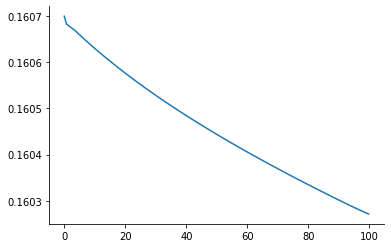

In [24]:
plt.plot(years, htdict[0.002])

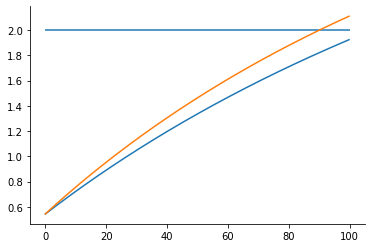

In [25]:
plt.plot(years,ytdict[0.002])
plt.plot(years, ytdict[1000])
plt.hlines(y=2,xmin=0,xmax=100)

(0.0, 14.0)

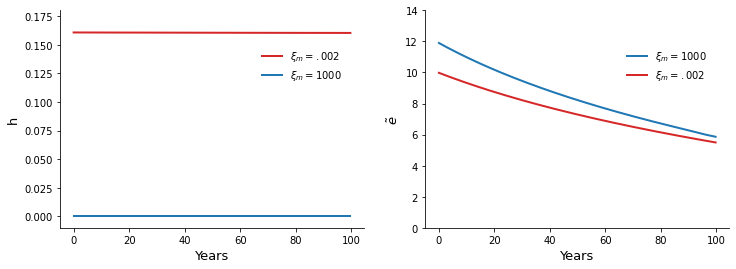

In [26]:
# plot 1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.plot(years, htdict[0.002], color='C3', label=r'$\xi_m = .002$', linewidth=2.)
ax1.plot(years, htdict[1000], color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('h', fontsize=13)
ax1.legend(frameon=False, loc=(0.65,.65))
ax1.set_ylim(-0.01, 0.18)

ax2.plot(years, etdict[1000], color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
ax2.plot(years, etdict[0.002], color='C3', label=r'$\xi_m = .002$', linewidth=2.)

ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc=(0.65,.65))
ax2.set_ylim(0., 14.)

# fig.savefig('../figures/h_ems.pdf')

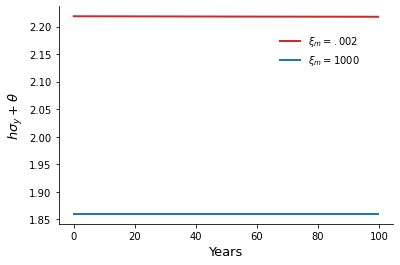

In [27]:
# plot 2
fig, ax1  = plt.subplots(1, 1,figsize=(6,4))
ax1.plot(years, (htdict[0.002]*σy + θ)*1000, color='C3', label=r'$\xi_m = .002$', linewidth=2.)
ax1.plot(years, (htdict[1000]*σy + θ)*1000, color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('$h\sigma_y + θ$', fontsize=13)
ax1.legend(frameon=False, loc=(0.65,.7))
# ax1.set_ylim(-0.01, 0.12)

# ax2.plot(years, etdict[0.004], color='C3', label=r'$\xi_m = .004$', linewidth=2.)
# ax2.plot(years, etdict[1000], color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
# ax2.set_xlabel('Years', fontsize=13)
# ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
# ax2.legend(frameon=False, loc=(0.65,.7))
# ax2.set_ylim(0., 14.)

# fig.savefig('../figures/hsigma_theta.pdf')

## With hotelling constraint
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & \quad b \delta\eta \log\tilde e \\
&  + b \frac{\xi_m}{2} h'h + \frac{dV}{dy} \tilde e (\theta + \sigma_y h) - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h) - \ell \tilde e
\end{aligned}
$$

$$
h^* = - \frac{\frac{dV}{dy} + b(\eta-1)(\gamma_1 + \gamma_2 y)}{b \xi_m} \cdot \tilde e \sigma_y
$$
Plug back into the HJB:
$$
\begin{aligned}
0 = \max_{\tilde e } \quad & b \delta\eta \log \tilde e + \frac{dV}{dy} \tilde e \theta - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2 \\ 
& +  b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot \theta - \ell \tilde e \\
& -\frac{1}{2b\xi_m}\left(\frac{dV}{dy} + b(\eta-1)(\gamma_1 + \gamma_2 y)\right)^2 (\tilde e)^2 |\sigma_y|^2
\end{aligned}
$$
First order condition for $\tilde e ^*$:
$$
  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b(\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2}\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \left[\frac{dV}{dy}\theta + b(\eta - 1)(\gamma_1 + \gamma_2 y)\theta - \ell \right]\tilde e + b \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b(\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2}\right] \cdot|\sigma_y|^2
$$

$$
B = \left[\frac{dV}{dy} + b(\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta - \ell
$$ 

$$
C = b \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [ ]:
# grid setting
b_grid = np.linspace(1e-10, 1, 50)
y_grid = np.linspace(1e-10, 10, 50)
# mesh grid and construct state space
(y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), b_mat.reshape(-1,1,order='F')])
hb = b_grid[1] - b_grid[0]
hy = y_grid[1] - y_grid[0]

In [269]:
# 2 state HJB with constraints
def solve_with_constraint(y_grid, b_grid, args, tol=1e-8, ϵ=0.3):
    """
    compute ϕ and emission with hotelling constraint
    """
    δ, η, θ_list, σy, ℓ, γ1, γ2, γ3, ξₘ, ξₐ = args
    # grid points
    hb = b_grid[1] - b_grid[0]
    hy = y_grid[1] - y_grid[0]
    (y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
    n_y, n_z = y_mat.shape
    stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), b_mat.reshape(-1,1,order='F')])
    # initiate whole loop
    episode = 0
    lhs_error = 1
    πo = np.ones((len(θ_list), n_y, n_z))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_z))/len(θ_list)
    dΛ = γ1 + γ2*y_mat + γ3*(y_mat - ȳ)*(y_mat>ȳ)
    ems = - δ*η/(b_mat*(η-1)*dΛ*θ)
    ems_old = ems
    while lhs_error > tol:
        if episode ==0:
            v0 =  - δ*η*y_mat**2
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,hy)
        v0_dyy = derivatives_2d(v0,0,2,hy)
        v0_db = derivatives_2d(v0,1,1,hb)
        # updating controls
        temp = v0_dy + b_mat*(η-1)*dΛ
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_mat])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        print(np.min(ems))
        
        a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2
        b = np.sum(θ_mat*π, axis=0)*temp  - ℓ
        c = δ*η*b_mat
        Δ = b**2 - 4*c*a
        Δ[Δ<0] = 0
        ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new
        # HJB coefficient
        A =  np.zeros(y_mat.shape)
        B_y =  np.sum(θ_mat*π, axis=0)*ems
        B_b = - δ*b_mat
        C_yy = ems**2*σy**2/2
        C_bb = np.zeros(y_mat.shape)
        D = b_mat*δ*η*np.log(ems) + b_mat*(η-1)*dΛ*ems*np.sum(θ_mat*π, axis=0) - ℓ*ems \
        - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)\
        + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode,
              rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
        print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    return v0, ems

In [261]:
ℓ = 1e-6
γ3 = np.average(γ3_list, weights=[0.5,0.5])
args = (δ, η, θ, σy, ℓ, γ1, γ2, γ3, ξₘ)
ϕ_2d, ems_2d = solve_with_constraint(y_grid, b_grid, args)

ValueError: not enough values to unpack (expected 10, got 9)

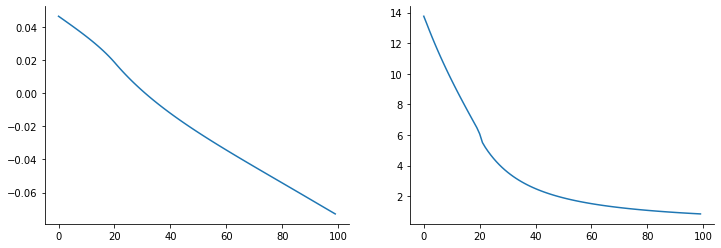

In [177]:
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(ϕ_2d[:,-1])
plt.subplot(122)
plt.plot(ems_2d[:,-1])

In [ ]:
import pandas as pd
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ/3
ℓ_step = 1e-15
ξₘ = 1000
ξₐ = 1000
ϕ_2d_dict = dict()
ems_2d_dict = dict()
for ℓ in [1e-12, 1e-6]:
    args = (δ, η, θ_list, σy, ℓ, γ1, γ2, γ3, ξₘ, ξₐ)
    ϕ_2d_dict[ℓ], ems_2d_dict[ℓ] = solve_with_constraint(y_grid, b_grid, args)
    args = (δ, η, θ_list, σy, ℓ+ℓ_step, γ1, γ2, γ3, ξₘ, ξₐ)
    ϕ_2d_dict[ℓ+ℓ_step], ems_2d_dict[ℓ_step] = solve_with_constraint(y_grid, b_grid, args)

0.8808268693443392
Episode 0: PDE Error: 0.002034205742; False Transient Error: 0.000608292971; Iterations: 10967; CG Error: 0.000000000098
End of PDE solver, takes time: 2.349670886993408
1.1907853491222947e-05
Episode 1: PDE Error: 0.002027643239; False Transient Error: 0.000606330779; Iterations: 10967; CG Error: 0.000000000098
End of PDE solver, takes time: 2.3402788639068604
1.1907853491009819e-05
Episode 2: PDE Error: 0.002021102596; False Transient Error: 0.000604374863; Iterations: 10967; CG Error: 0.000000000095
End of PDE solver, takes time: 2.3414905071258545
1.1907853490882965e-05
Episode 3: PDE Error: 0.002014582878; False Transient Error: 0.000602425214; Iterations: 10966; CG Error: 0.000000000100
End of PDE solver, takes time: 2.3562605381011963
1.1907853490736795e-05
Episode 4: PDE Error: 0.002008084048; False Transient Error: 0.000600481836; Iterations: 10959; CG Error: 0.000000000098
End of PDE solver, takes time: 2.33911395072937
1.1907853492989443e-05
Episode 5: PDE

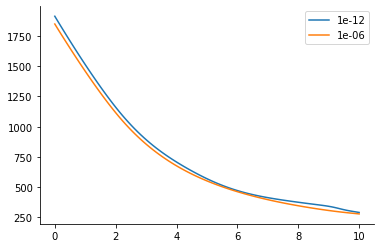

In [202]:
for ℓ in [1e-12, 1e-6]:
    plt.plot(y_grid, - (ϕ_2d_dict[ℓ+ℓ_step][:,-1] - ϕ_2d_dict[ℓ][:,-1])/ℓ_step, label="{}".format(ℓ))
plt.legend()